# Band Ratios for KBOs

The molecules in crystalline ice are arranged in a repeating pattern, while the molecules in amorphous ice are randomly arranged. In addition to their difference in molecular arrangement, crystalline and amorphous ice differ spectroscopically. Both types of ice have features at 1.5 microns and 2 microns, but the 1.65 micron feature is different for crystalline and amorphous ice. By measuring the band ratio of the 1.65 micron feature to the 1.5 micron feature, it is possible to determine the degree of crystallinity. This method, described by Fink and Larson (1975), involves measuring the area of the 1.65 micron band and comparing it to the full 1.5 micron band, which extends from 1.4 to 1.8 microns. A sample of the band areas used in this method are shown in Figure 9 of Grundy and Schmitt (1998).

A similar method is used by Mastrapa and Brown (2006). To perform the method, a baseline is drawn from approximately 1.4 to 1.8 microns on the spectrum (purple line below). A second baseline is drawn from approximately 1.6 to 1.8 microns (green line below). The ratio of the area under the second baseline (green shaded) to the area under the first (purple shaded) is used to determine whether or not an object has crystalline water ice. The resulting area ratio is offset by 0.1 from the ratios found by Grundy and Schmitt (1998). In either case, the ratio of band areas can be used to determine the temperature of ice. Figures 6 and 7 of Mastrapa and Brown (2006) illustrate the dependence of the band area ratio on temperature. The result is that amorphous ice has a band area ratio of about 0.03, whereas crystalline ice at a temperature of 50 K has a ratio of about 0.10.

![Example Ratio](img/example_ratio.png)

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import linregress
from scipy.signal import argrelextrema

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [10, 5] # Make plots bigger
plt.rcParams.update({'font.size': 14}) # Make font size bigger

In [3]:
%%javascript
// Disable auto scroll for plots
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [4]:
# Define where the data are and get a list of files
data_dir = '../../data'
file_list = os.listdir(data_dir)

# Set the minimum and maximum micron values for the whole spectrum range
min_micron = 1.4
max_micron = 1.69

# Set the minimum micron value for the 1.65 micron feature. This is typically around 1.626.
min_micron_165 = 1.626

# Set a few values for dataframe columns
wl_string = 'wavelength'
refl_string = 'reflectance'
line_string = 'line'

# Set plot colors
color_full_area = 'purple'
color_165_area = 'green'

In [5]:
def find_slope_intercept(df):
    """ Find the slope and intercept  between a line drawn from the first point to the last point
        of a sorted dataframe of wavelengths and reflectances. Uses scipy stats linregress.
        
        See: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
        
        Parameters:
        df (pandas.dataframe): dataframe with columns wavelength and reflectance
        
        Returns:
        float: slope of line between first and last points
        float: intercept
    """
    wavelength_start = df[wl_string].iloc[0]
    wavelength_stop = df[wl_string].iloc[-1]
    reflectance_start = df[refl_string].iloc[0]
    reflectance_stop = df[refl_string].iloc[-1]

    slope, intercept, _, _, _ = linregress([wavelength_start, wavelength_stop],
                                           [reflectance_start, reflectance_stop])
    return slope, intercept

In [6]:
def plot_spectrum(df, color):
    """Find the slope and intercept  between a line drawn from the first point to the last point
    of a sorted dataframe of wavelengths and reflectances.
        
    Parameters:
    df (pandas.core.frame.DataFrame): dataframe with columns wavelength and reflectance
    color (str): string with a valid matplotlib color value for plotting
        
    Returns:
    numpy.float64: slope of line between first and last points
    numpy.float64: intercept
    
    """
    plt.scatter(df[wl_string], df[refl_string], color=color)
    plt.plot(df[wl_string], df[line_string], color=color)
    
    # Plot the fill between the line and the spectrum points. alpha sets a transparency.
    plt.fill(np.append(df[wl_string], df[wl_string][::-1]), 
             np.append(df[line_string], df[refl_string][::-1]), color, alpha=0.25)

In [7]:
def find_area(df):
    """Find the difference in the area under the curve for a line between the start and
    end points and the reflectance values for a sorted dataframe. Uses the trapz function
    from numpy to find the integrated areas.
    
    See: https://numpy.org/doc/stable/reference/generated/numpy.trapz.html
        
    Parameters:
    df (pandas.core.frame.DataFrame): dataframe with columns wavelength and reflectance
        
    Returns:
    numpy.float64: difference in area
    
    """
    area_below_line = np.trapz(df[line_string], df[wl_string]) # Area below the line between the start and end points
    area_below_point = np.trapz(df[refl_string], df[wl_string]) # Area below the reflectance curve
    diff_area = area_below_line - area_below_point
    return diff_area

In [8]:
def find_ratio(file):
    """Find the ratio of the area difference for the 1.65 micron spectral line to the 
    area difference for the entire spectrum.
        
    Parameters:
    file (str): string with file name
        
    Returns:
    
    """
    # Object name
    obj = file.replace('.txt', '') # replace .txt with blank space
    
    # Create a dataframe from csv data.
    #  sep (delimiter) is '/t' for tab, must set header to None
    df_spectrum_orig = pd.read_csv(os.path.join(data_dir,file), sep='\t', header=None, 
                              names=[wl_string, refl_string])
    
    # Filter the data between the min and max micron values
    df_spectrum = df_spectrum_orig[(df_spectrum_orig[wl_string] >= min_micron) &
                                  (df_spectrum_orig[wl_string] < max_micron)]
    
    # Sort the dataframe inplace by wavelength then reflectance
    df_spectrum.sort_values(by=[wl_string, refl_string], ascending=True, inplace=True)
    
    # Reset the dataframe indices
    df_spectrum.reset_index(inplace=True)
    
    # Uncomment the next line to plot just the spectrum
    # df_spectrum.plot(x=wl_string, y=refl_string, kind='scatter', title=obj)
    
    # Find the slope and intercept; create a new column in the dataframe with the line values
    slope, intercept = find_slope_intercept(df_spectrum)
    df_spectrum[line_string] = slope * df_spectrum[wl_string] + intercept # y = mx + b
    
    # Uncomment next line to plot the spectrum and the line between first and last points
    # df_spectrum.plot(x=wl_string, y=[refl_string,line_string], title=obj)
    
    # Find the index where the 1.65 micron spectral feature starts.
    ind_list = df_spectrum[df_spectrum[wl_string] == min_micron_165].index
    
    # Take the last index from the list
    if len(ind_list > 0):
        ind_max = ind_list[-1]
    # If there are no values in the index list, look for the index of the last value before the
    # stated start value.
    else:
        ind_list = df_spectrum[df_spectrum[wl_string] < min_micron_165].index
        ind_max = ind_list[-1]
    
    # Define a new dataframe just with the data for the 1.65 micron feature and reset indices
    df_spectrum_165 = df_spectrum[df_spectrum.index >= ind_max].drop(line_string, axis=1)
    df_spectrum_165.reset_index(inplace=True)
    
    # Find the slope and index for the line between the first and last points of the 1.65 micron 
    #  feature. Create a new column in the dataframe to hold the line values.
    slope_165, intercept_165 = find_slope_intercept(df_spectrum_165)
    df_spectrum_165[line_string] = slope_165 * df_spectrum_165[wl_string] + intercept_165
    
    # Find the ratio of area difference of the complete spectrum to the area difference of the 
    #  1.65 micron feature
    area_total = find_area(df_spectrum)
    area_165 = find_area(df_spectrum_165)
    ratio = area_165 / area_total
    
    # Plot the full spectrum and 1.65 micron feature areas
    plt.figure()
    plot_spectrum(df_spectrum, color_full_area) # Full spectrum
    plot_spectrum(df_spectrum_165, color_165_area) # 1.65 micron feature
    plt.ylabel('Relative Reflectance')
    plt.xlabel('Wavelength [microns]')
    plt.title(f'{obj}: ratio={ratio:.3}') # The .3 means print 3 sig figs

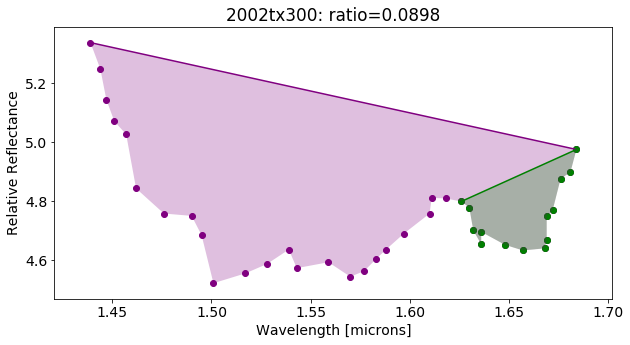

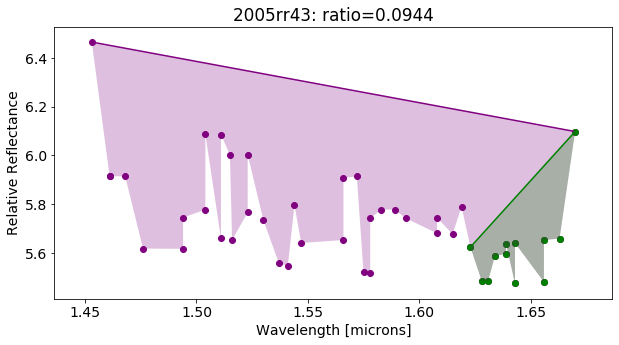

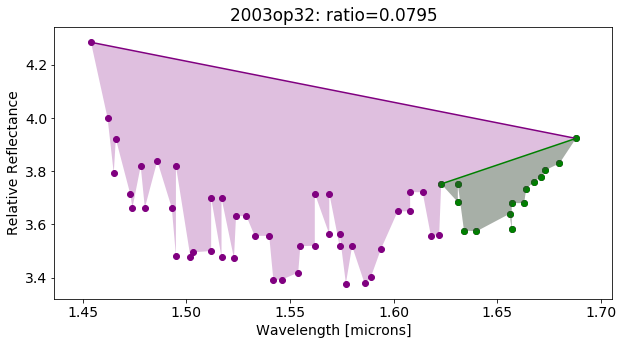

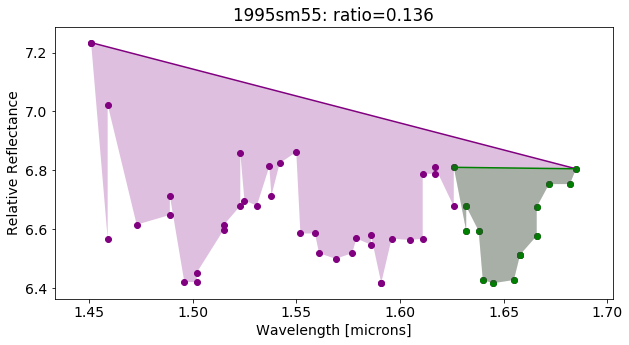

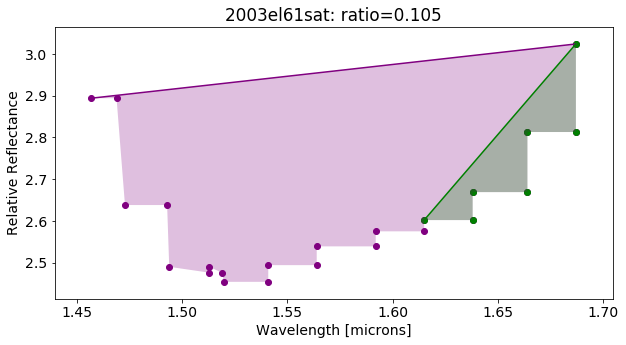

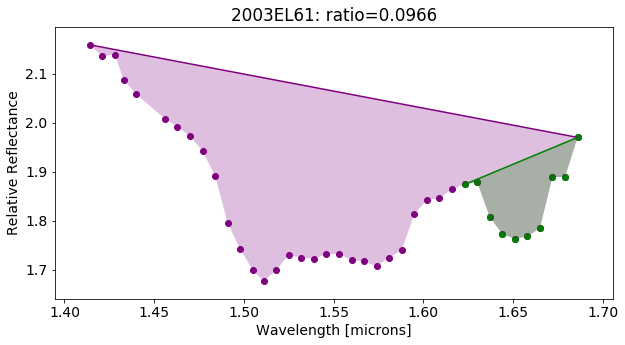

In [9]:
# These first two lines suppress unhelpful pandas warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for file in file_list:
        find_ratio(file)